## 1. Nhập thư viện

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_f1_score
from sklearn_crfsuite.metrics import flat_classification_report

c:\Users\ADMIN\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 2. Nhập file

In [2]:
#Reading the csv file
df = pd.read_csv("Annotated/GMB_dataset.txt", sep="\t", encoding="latin1")
del df['Unnamed: 0']

#### 2.1. Df với POS_tag test

In [3]:
#Display first 10 rows
df.head(10)

,Sentence #,Word,POS,Tag
0,1.0,Thousands,NNS,O
1,1.0,of,IN,O
2,1.0,demonstrators,NNS,O
3,1.0,have,VBP,O
4,1.0,marched,VBN,O
5,1.0,through,IN,O
6,1.0,London,NNP,B-geo
7,1.0,to,TO,O
8,1.0,protest,VB,O
9,1.0,the,DT,O


In [4]:
#Displaying the unique Tags
df['Tag'].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

There are lots of missing values in 'Sentence #' attribute. So we will use pandas fillna technique and use 'ffill' method which propagates last valid observation forward to next.

## 3. Xử lý các giá trị sentence null trong df

In [5]:
df = df.fillna(method = 'ffill')

In [6]:
# This is a class te get sentence. The each sentence will be list of tuples with its tag and pos.
class sentence(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                       s['POS'].values.tolist(),
                                                       s['Tag'].values.tolist())]
        self.grouped = self.df.groupby("Sentence #").apply(agg)
        self.sentences = [s for s in self.grouped]
        
    def get_text(self):
        try:
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None

## 4. Ghép các từ đơn từ df thành list của các câu

In [7]:
#Displaying one full sentence
getter = sentence(df)
text = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
text[0]

'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .'

## 5. List của POS_TAG ứng với từng từ trong câu

Getting all the sentences in the dataset.

In [8]:
docsPOS = getter.sentences
docsPOS[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

## 6. Nhập thư viện xử lý 

In [9]:
import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
from nltk import sent_tokenize, word_tokenize, pos_tag

In [10]:
len(text)

2999

In [11]:
text[:2]

['Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .',
 'Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings . "']

## 7. Tạo POS_predict

In [12]:
pos_tag_predict_list = []  # Danh sách để lưu kết quả

for sentence in text:
    tokens = word_tokenize(sentence)
    pos_tags = pos_tag(tokens)
    pos_tag_predict_list.append(pos_tags)  # Thêm kết quả của mỗi câu vào danh sách

In [13]:
pos_tag_predict_list[:1]

[[('Thousands', 'NNS'),
  ('of', 'IN'),
  ('demonstrators', 'NNS'),
  ('have', 'VBP'),
  ('marched', 'VBN'),
  ('through', 'IN'),
  ('London', 'NNP'),
  ('to', 'TO'),
  ('protest', 'VB'),
  ('the', 'DT'),
  ('war', 'NN'),
  ('in', 'IN'),
  ('Iraq', 'NNP'),
  ('and', 'CC'),
  ('demand', 'VB'),
  ('the', 'DT'),
  ('withdrawal', 'NN'),
  ('of', 'IN'),
  ('British', 'JJ'),
  ('troops', 'NNS'),
  ('from', 'IN'),
  ('that', 'DT'),
  ('country', 'NN'),
  ('.', '.')]]

In [14]:
pos_tag_predict_list = [[(word, tag) for word, tag, _ in doc] for doc in docsPOS]
pos_tag_predict_list[:1]

[[('Thousands', 'NNS'),
  ('of', 'IN'),
  ('demonstrators', 'NNS'),
  ('have', 'VBP'),
  ('marched', 'VBN'),
  ('through', 'IN'),
  ('London', 'NNP'),
  ('to', 'TO'),
  ('protest', 'VB'),
  ('the', 'DT'),
  ('war', 'NN'),
  ('in', 'IN'),
  ('Iraq', 'NNP'),
  ('and', 'CC'),
  ('demand', 'VB'),
  ('the', 'DT'),
  ('withdrawal', 'NN'),
  ('of', 'IN'),
  ('British', 'JJ'),
  ('troops', 'NNS'),
  ('from', 'IN'),
  ('that', 'DT'),
  ('country', 'NN'),
  ('.', '.')]]

In [15]:
# Tạo một từ điển (dictionary) để ánh xạ từ (word) với tag
word_to_tag_mapping = {}
for sentence in pos_tag_predict_list:
    for word, tag in sentence:
        word_to_tag_mapping[word] = tag

# Tạo danh sách "POS_predict" dựa trên ánh xạ từ (word) với tag
df["POS_predict"] = [word_to_tag_mapping.get(word, "O") for word in df["Word"]]


In [16]:
# pos_predict = [pos for sentence in pos_tag_predict_list for (_, pos) in sentence]
# pos_predict[:1]

In [17]:
# len(pos_predict)

## 8. Đánh giá model POS_tag do NLTK thực hiện

### a. Confusion matrix: ví dụ đối với 2 nhãn JJ và VBN

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score
from sklearn import metrics
confusion_matrix = confusion_matrix(df['POS'].to_list(), df['POS_predict'].to_list(), labels = ['JJ', 'VBN'])

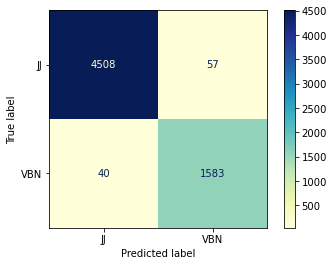

In [19]:
import seaborn as sns
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['JJ', 'VBN'])
cm_display.plot(cmap="YlGnBu")
plt.show()

### b. Accuracy

In [20]:
accuracy = accuracy_score(df['POS'].to_list(), df['POS_predict'].to_list())
accuracy

0.9483683741176826

### c. Precision

In [21]:
overall_precision = precision_score(df['POS'].to_list(), df['POS_predict'].to_list(), average='micro')
print("Overall Precision:", overall_precision)

Overall Precision: 0.9483683741176826


### d. Recall

In [22]:
recall = recall_score(df['POS'].to_list(), df['POS_predict'].to_list(), labels=['JJ', 'VBN'], average='micro')
print("Overall Recall:", recall)

Overall Recall: 0.8782984859408796


### e. Classification_report

In [23]:
from sklearn.metrics import classification_report
print('Tổng số thực thể: ', len(df['POS_predict']))
print(classification_report(df['POS'].to_list(), df['POS_predict'].to_list()))

Tổng số thực thể:  66161


c:\Users\ADMIN\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           $       1.00      1.00      1.00        61
           ,       1.00      1.00      1.00      1954
           .       1.00      1.00      1.00      2992
           :       0.59      1.00      0.74        54
           ;       1.00      1.00      1.00        20
          CC       1.00      1.00      1.00      1475
          CD       1.00      1.00      1.00      1474
          DT       1.00      0.99      0.99      6310
          EX       0.81      1.00      0.90        43
          IN       0.97      0.99      0.98      7759
          JJ       0.92      0.92      0.92      4875
         JJR       0.95      0.44      0.60       198
         JJS       0.91      0.97      0.94       179
         LRB       1.00      1.00      1.00        43
          MD       1.00      1.00      1.00       454
          NN       0.95      0.94      0.95      9307
         NNP       0.96      0.98      0.97      8189
        NNPS       0.70    

c:\Users\ADMIN\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
